In [1]:
from cycle_dataset import *
from evaluation import *
import tqdm
from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import networkx as nx
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300


In [331]:
from collections import defaultdict
import scipy.stats

In [251]:
epoch = 60
params = 'train/sgvae5/cycles{}.params'.format(epoch)
sgvae = torch.load(params)

In [252]:

def iscycle(g):
    #g = deepcopy(g)
    node = 0
    seen = set()
    neighbors = g.successors(node)
    if len(neighbors) != 2:
        return False
    #g.remove_nodes([node])
    seen.add(node)
    node = neighbors[0]
    while True:
        #outputfile.write(str(seen) + 'SEEN\n')
        #outputfile.flush()
        initneighbors = set(int(f) for f in g.successors(node))
        if len(initneighbors) != 2: return False
        neighbors = set(int(f) for f in g.successors(node)) - seen
        #outputfile.write(str(neighbors) + 'NEIGHBORS\n')
        #outputfile.flush()
        
        if len(neighbors) != 1: break
        #g.remove_nodes([node])
        seen.add(int(node))
        node = list(neighbors)[0]
    return g.number_of_nodes() - len(seen) == 1 #and 0 in [int(f) for f in g.successors(node)] and len(g.successors(node)) == 2
    #return g.number_of_nodes() == 1
        


In [253]:
def generateData(sgvae):
    zs = []
    N_DUP = 40
    labels = []
    for i in range(5, 15):
        g = create_cycle_with_size(i)
        for _ in trange(N_DUP):
            z = sgvae.encoder(deepcopy(g))[0]
            zs.append(z)
            labels.append(i)
    zs = torch.cat(zs, dim=0).detach().numpy()
    labels = np.array(labels)
    
    return zs, labels

In [311]:
zs, labels = generateData(sgvae)


100%|██████████| 40/40 [00:00<00:00, 89.07it/s]

100%|██████████| 40/40 [00:00<00:00, 79.68it/s]

100%|██████████| 40/40 [00:00<00:00, 67.77it/s]

100%|██████████| 40/40 [00:00<00:00, 53.98it/s]

100%|██████████| 40/40 [00:00<00:00, 49.88it/s]

100%|██████████| 40/40 [00:00<00:00, 40.49it/s]

100%|██████████| 40/40 [00:01<00:00, 39.90it/s]

100%|██████████| 40/40 [00:01<00:00, 34.11it/s]

100%|██████████| 40/40 [00:01<00:00, 30.20it/s]

100%|██████████| 40/40 [00:01<00:00, 31.15it/s]


In [312]:
zs_embedded = TSNE(n_components=2).fit_transform(zs)    

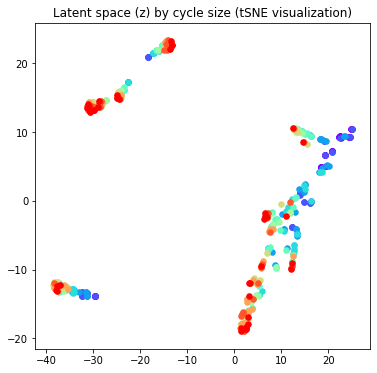

In [313]:
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(6, 6))
for i in range(5, 15):
    plt.scatter(zs_embedded[labels==i][:, 0], zs_embedded[labels==i][:, 1], label=str(i), color=colors[i-5], s=30)
#plt.legend(loc='lower left',  bbox_to_anchor=(0, 0., 0.5, 0.5), fontsize='large')
plt.title("Latent space (z) by cycle size (tSNE visualization)")
plt.show()

In [314]:
major_indices = np.where((zs_embedded[:, 0] > -0) & (zs_embedded[:, 1] <20) )[0]
zs_analysis, labels_analysis = zs[major_indices], labels[major_indices]
print(f"Analyzing {len(major_indices)/len(zs_embedded)*100:.3f}% of the data.")

Analyzing 62.250% of the data.


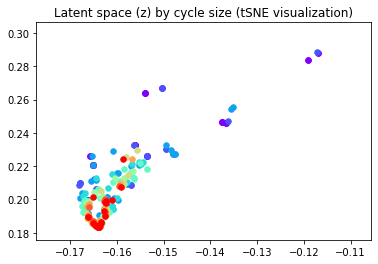

In [316]:
for i in range(5, 15):
    plt.scatter(zs_analysis[labels_analysis==i][:, 0], zs_analysis[labels_analysis==i][:, 1], label=str(i), color=colors[i-5], s=30)
#plt.legend(loc='lower left',  bbox_to_anchor=(0, 0., 0.5, 0.5), fontsize='large')
plt.title("Latent space (z) by cycle size (tSNE visualization)")
plt.show()

In [317]:
pca = PCA(n_components=1)
zs_analysis_transformed = pca.fit_transform(zs_analysis)
print(pca.__dict__)

{'n_components': 1, 'copy': True, 'whiten': False, 'svd_solver': 'auto', 'tol': 0.0, 'iterated_power': 'auto', 'random_state': None, '_fit_svd_solver': 'full', 'mean_': array([-0.16002347,  0.20694177, -0.20739399, -0.04901777,  0.25574958],
      dtype=float32), 'noise_variance_': 9.056495e-05, 'n_samples_': 249, 'n_features_': 5, 'components_': array([[ 0.11738829,  0.34668085, -0.69686204, -0.5942732 , -0.16509166]],
      dtype=float32), 'n_components_': 1, 'explained_variance_': array([0.00425328], dtype=float32), 'explained_variance_ratio_': array([0.9215131], dtype=float32), 'singular_values_': array([1.0270416], dtype=float32)}


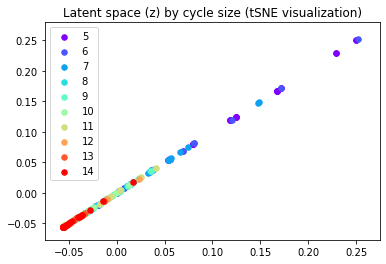

In [318]:
for i in range(5, 15):
    plt.scatter(zs_analysis_transformed[labels_analysis==i], zs_analysis_transformed[labels_analysis==i], label=str(i), color=colors[i-5], s=30)
plt.legend()
plt.title("Latent space (z) by cycle size (tSNE visualization)")
plt.show()

In [319]:
print(pca.components_)

[[ 0.11738829  0.34668085 -0.69686204 -0.5942732  -0.16509166]]


In [320]:
lin = list(np.linspace(-0.06, 0.25, 10))
print(lin)

[-0.06, -0.025555555555555554, 0.00888888888888889, 0.043333333333333335, 0.07777777777777778, 0.11222222222222222, 0.14666666666666667, 0.1811111111111111, 0.21555555555555556, 0.25]


In [356]:
def stats(counts):
    return [counts.count(i)/len(counts) for i in range(15)]
    

In [362]:
z = pca.inverse_transform(lin[0]).astype(np.float32)
N = 1000
graph_sizes = defaultdict(list)
i = 0
for val in lin:
    for i in range(N):
        with torch.no_grad():
            graph = sgvae.decoder(z)[0]
            if iscycle(graph) and graph.number_of_nodes():
                graph_sizes[val].append(graph.number_of_nodes())
    print(val)
    #stats(graph_sizes[val])
    


-0.06
-0.025555555555555554
0.00888888888888889
0.043333333333333335
0.07777777777777778
0.11222222222222222
0.14666666666666667
0.1811111111111111
0.21555555555555556
0.25


Text(0.5, 0, 'Principal axis interpolation')

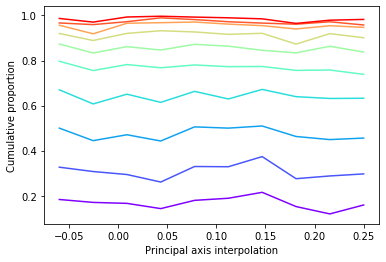

In [373]:
lists = [np.cumsum(stats(graph_sizes[val])) for val in sorted(graph_sizes.keys())]
lists = list(zip(*lists))

colors = cm.rainbow(np.linspace(0, 1, 10))

#fig, ax = plt.subplots(figsize=(8, 5))
for i in range(5, 15):
    plt.plot(lin, lists[i], color=colors[i-5], label=str(i))
#plt.legend()
plt.ylabel('Cumulative proportion')
plt.xlabel('Principal axis interpolation')
#plt.title('Distribution of cycle lengths interpolating along the principle axis')

In [364]:
means = [np.mean(graph_sizes[val]) for val in sorted(graph_sizes.keys())]

In [376]:
stderrs = [np.std(graph_sizes[val])/len(graph_sizes[val]) for val in sorted(graph_sizes.keys())]

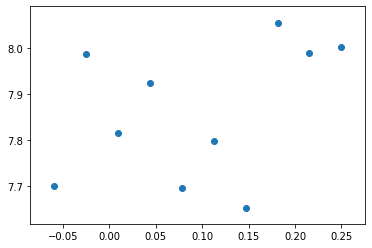

In [365]:
plt.scatter(lin, means)

In [377]:
stderrs

[0.008526646685755408,
 0.010531201097150746,
 0.008537304128955371,
 0.008798607699459024,
 0.008938918756682053,
 0.009022181029203614,
 0.010495775071402903,
 0.009737516232418248,
 0.008706976314820859,
 0.009442850714190609]

In [366]:
scipy.stats.linregress(lin, means)

LinregressResult(slope=0.566614466451233, intercept=7.808776217974137, rvalue=0.3983704415853216, pvalue=0.2541897045073127, stderr=0.46124456127684726)